In [4]:
#import packages internal and external
import tests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import pandas as pd
import datasetBuilder
import tools
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.base
import pickle
import copy
import tests
from sklearn.metrics import roc_auc_score as auc
import os
import plotAndOrderResults
import datasetBuilder
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
#Set path variables where we want to save created datasets, intermediate outputs, etc
#If you want to run this on your own computer, obviously you should update the path

outputs_path='/Users/jonahpoczobutt/projects/specsim_res/testy'
os.mkdir(outputs_path)


nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
nist23_hr_prot_deprot_only = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_prot_deprot_only.pkl'
nist23_hr_full ='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_full.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_highres_inst.pkl'
mona_nist = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_nist_prot_only.pkl'

#Set the query and target dbs
#these can be different or the same
query = nist23_hr_full
target = nist23_hr_full

#This variable toggles whether we do a full run of the notebook, or if we read in variables created in a previous run
fullRun=True

#create directories for results
if fullRun:
    
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/matchStats')
    os.mkdir(f'{outputs_path}/intermediateOutputs/fullSearchMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/quantileDfs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/modelDatasets')
    os.mkdir(f'{outputs_path}/intermediateOutputs/models')
    os.mkdir(f'{outputs_path}/fig1')
    os.mkdir(f'{outputs_path}/fig2')
    os.mkdir(f'{outputs_path}/fig3')
    os.mkdir(f'{outputs_path}/fig4')
    os.mkdir(f'{outputs_path}/fig4/a')
    os.mkdir(f'{outputs_path}/fig4/b')
    os.mkdir(f'{outputs_path}/fig5')
    os.mkdir(f'{outputs_path}/fig5/a')
    os.mkdir(f'{outputs_path}/fig5/b')


Preprocessing: Creating Target and Matches DFs


In [3]:
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    #this method is in place
    np.random.shuffle(all_bases)

    first_bases = all_bases[:int(len(all_bases)*0.6)]
    second_bases = all_bases[int(len(all_bases)*0.6):int(len(all_bases)*0.7)]
    third_bases = all_bases[int(len(all_bases)*0.7):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],second_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    del(second_query_)

    third_query_ = query_[np.isin(query_['inchi_base'],third_bases)]
    third_query_.reset_index(inplace=True)
    third_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    del(third_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/second_bases.npy',second_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/third_bases.npy',third_bases)
    del(first_bases)
    del(second_bases)
    del(third_bases)
    del(all_bases)


Figure 1: Global Performance of Individual Metrics/Weighting Schemes

In [3]:
#these are the ppm windows that we want to test
ppm_windows = [10]

#this is the size of the sample we take from the full target
size=int(2e6)

#this is the maximum number of matches we allow for each query, based on the precursor window
max_matches=None

#adduct match
adduct_match=False

#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,'orig','normalent']
sim_methods=None
prec_removes=[True, False]

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload queries and target for individual comparison
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    #shuffle query to ensure random subset
    query_.sample(frac=1)

    for i in ppm_windows:

        #create a new matches df for each ppm window
        matches = datasetBuilder.create_matches_df_new(query_,target_,i,max_matches,size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')

        #comparison on large sample
        tests.create_variable_comparisons(
                                noise_threshes=noise_threshes,
                                centroid_threshes=centroid_tolerance_vals,
                                centroid_types=centroid_tolerance_types,
                                powers=powers,
                                sim_methods=sim_methods,
                                prec_removes=prec_removes,
                                matches=matches,
                                outpath = f'{outputs_path}/fig1/{i}_ppm.csv',
                                )

                                               query  \
0  [[55.04070107526883, 0.018607480932389484], [6...   
1  [[55.04070107526883, 0.018607480932389484], [6...   
2  [[55.04070107526883, 0.018607480932389484], [6...   
3  [[55.04070107526883, 0.018607480932389484], [6...   
4  [[55.04070107526883, 0.018607480932389484], [6...   

                                             library  
0  [[86.0966, 0.07046714261513255], [87.1, 0.0528...  
1  [[57.0698, 0.04406394265707068], [151.0179, 0....  
2  [[166.0056, 0.24842167765164766], [240.0577, 0...  
3  [[258.0684, 0.3590641078685857], [360.067, 0.6...  
4  [[65.0382, 0.05969606647764886], [77.0382, 0.0...  
                                               query  \
0  [[55.04070107526883, 0.013765250671346709], [6...   
1  [[55.04070107526883, 0.013765250671346709], [6...   
2  [[55.04070107526883, 0.013765250671346709], [6...   
3  [[55.04070107526883, 0.013765250671346709], [6...   
4  [[55.04070107526883, 0.013765250671346709], [6... 

Figure 2: Assessing Metric Stability in Smaller Samples

In [5]:
#this is the size of the sample we take from the full target
size=2e3

#this is the number of times we want to take a sample of the above size
trials=100

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload target
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    for i in range(trials):

        os.mkdir(f'{outputs_path}/fig2/{i}')
        
        for j in ppm_windows:

            #create matches after shuffling query
            query_ = query_.sample(frac=1)
            matches = datasetBuilder.create_matches_df_new(query_,target_,j,max_matches,size, adduct_match)

            #comparison on small sample
            tests.create_variable_comparisons(
                                    noise_threshes=noise_threshes,
                                    centroid_threshes=centroid_tolerance_vals,
                                    centroid_types=centroid_tolerance_types,
                                    powers=powers,
                                    sim_methods=sim_methods,
                                    matches=matches,
                                    outpath = f'{outputs_path}/fig2/{i}/{j}_ppm.csv'
                                    )

error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
e

Matches Statistics

Unfiltered Spectral Entropy Queries


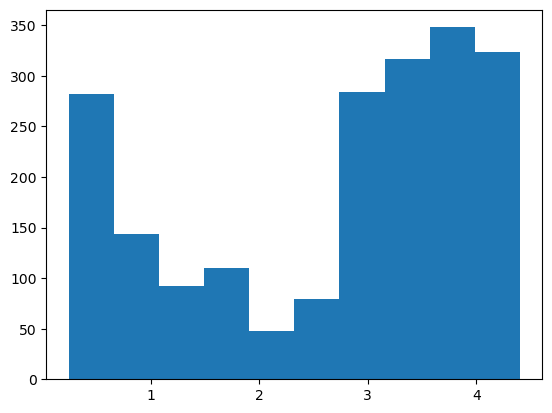

Unfiltered Spectral Entropy Retrieved Target


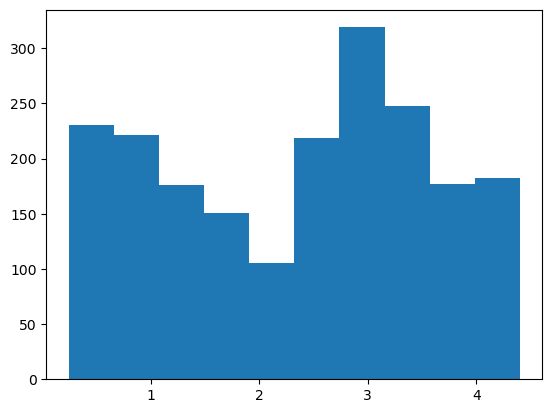

N peaks Queries


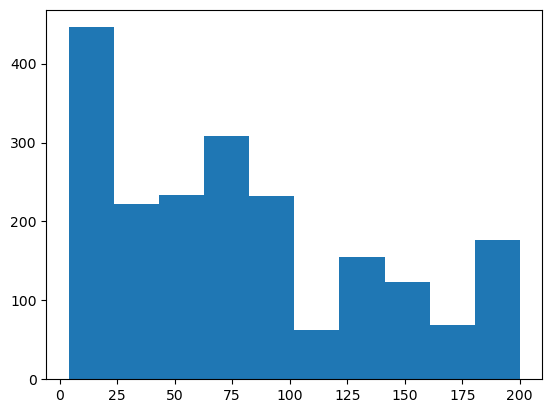

N peaks Target


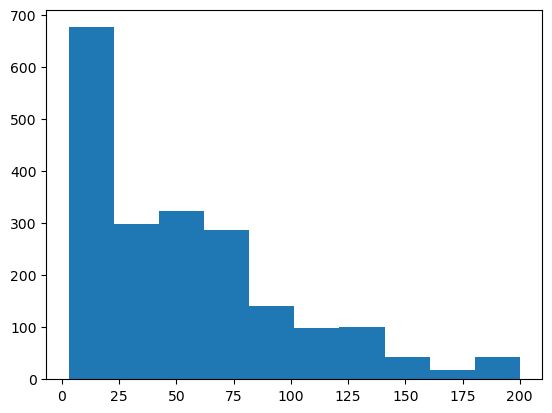

Histogram of Precursor Masses


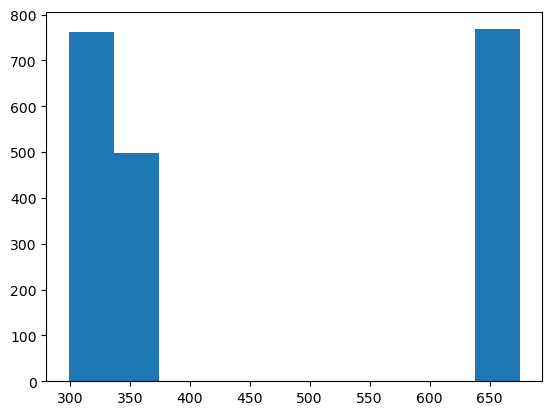

% True Inchicore Matches
0.4393491124260355


In [47]:
print('% True Inchicore Matches')
print(sum(matches['match'])/len(matches))

with open(f'{outputs_path}/matchStats/stats.txt','w') as res:
    res.write(f'base match rate: {sum(matches["match"])/len(matches)}')

print('Unfiltered Spectral Entropy Queries')
vals = [scipy.stats.entropy(i[:,1]) for i in matches['query']]
plt.hist(vals)
plt.savefig(f'{outputs_path}/matchStats/EntQueries.png')
plt.show()

with open(f'{outputs_path}/matchStats/stats.txt','w') as res:
    res.write(f'queries entropy mean/std: {np.mean(vals)} {np.std(vals)}')

print('Unfiltered Spectral Entropy Retrieved Target')
vals = [scipy.stats.entropy(i[:,1]) for i in matches['target']]
plt.hist(vals)
plt.savefig(f'{outputs_path}/matchStats/EntTarget.png')
plt.show()

with open(f'{outputs_path}/matchStats/stats.txt','w') as res:
    res.write(f'retrieved target entropy mean/std: {np.mean(vals)} {np.std(vals)}')

print('N peaks Queries')
vals = [len(i) for i in matches['query']]
plt.hist(vals)
plt.savefig(f'{outputs_path}/matchStats/PeaksQueries.png')
plt.show()

with open(f'{outputs_path}/matchStats/stats.txt','w') as res:
    res.write(f'queries n peaks mean/std: {np.mean(vals)} {np.std(vals)}')

print('N peaks Target')
vals = [len(i) for i in matches['target']]
plt.hist(vals)
plt.savefig(f'{outputs_path}/matchStats/PeaksTarget.png')
plt.show()

with open(f'{outputs_path}/matchStats/stats.txt','w') as res:
    res.write(f'target n peaks mean/std: {np.mean(vals)} {np.std(vals)}')

print('Histogram of Precursor Masses')
plt.hist(matches['prectarget'])
plt.savefig(f'{outputs_path}/matchStats/PrecMasses.png')
plt.show()

with open(f'{outputs_path}/matchStats/stats.txt','w') as res:
    res.write(f'precursor mass mean/std: {np.mean(matches["prectarget"])} {np.std(matches["prectarget"])}')

Figures 1 and 2

Top Metrics for 10_ppm.csv by AUC
                                      Metric       AUC            Vec Settings
161                          max_dot_product  0.665287       0.01_0.05_da_orig
441                          max_dot_product  0.664447        0.01_0.1_da_orig
231                          max_dot_product  0.663550  0.01_0.05_da_normalent
157                                 max_chi2  0.663030       0.01_0.05_da_orig
166  max_probabilistic_symmetric_chi_squared  0.663030       0.01_0.05_da_orig
146                        max_harmonic_mean  0.663030       0.01_0.05_da_orig
173                        max_entropy_jonah  0.662887       0.01_0.05_da_orig
511                          max_dot_product  0.662787   0.01_0.1_da_normalent
153                         max_intersection  0.662618       0.01_0.05_da_orig
164                               max_motyka  0.662618       0.01_0.05_da_orig
199                      max_manhattan_jonah  0.662618       0.01_0.05_da_orig
185               

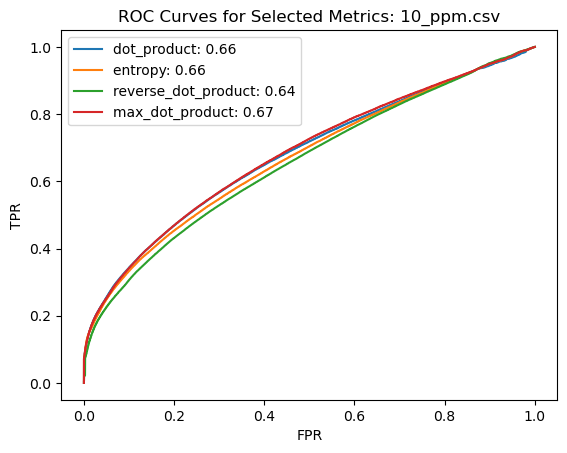

In [13]:
#first, generate tables from full size
reload(plotAndOrderResults)
reload(tests)
reload(datasetBuilder)
plotAndOrderResults.fig1(f'{outputs_path}/fig1',f'{outputs_path}/intermediateOutputs/fullSearchMatches', f'{outputs_path}/fig1')


In [14]:
#assess metric stability from small runs
reload(plotAndOrderResults)
plotAndOrderResults.fig2(f'{outputs_path}/fig2', ppm_windows)

Top Ranks and Means for 10 PPM: Metrics, 71 total
Proportion of Time This Metric is Top
                    index     0
4     pearson_correlation  0.12
13         mean_character  0.12
9              lorentzian  0.07
7               hellinger  0.06
14        max_common_mass  0.05
0     reverse_dot_product  0.04
28       binary_cross_ent  0.04
6                 entropy  0.04
11                roberts  0.03
23              cross_ent  0.03
20        max_dot_product  0.03
17         max_lorentzian  0.03
2             common_mass  0.03
3           max_laplacian  0.02
8        lorentzian_jonah  0.02
32            max_entropy  0.02
1   max_squared_euclidean  0.02
19      squared_euclidean  0.02
30          entropy_jonah  0.02
22      max_squared_chord  0.02


Mean Ranking By Metric
                                      index      0
15                                     chi2  21.30
18      probabilistic_symmetric_chi_squared  22.61
9                                   entropy  22.85
10         

Figure 3: Hierarchy of Metric Performance Conditional Distributions


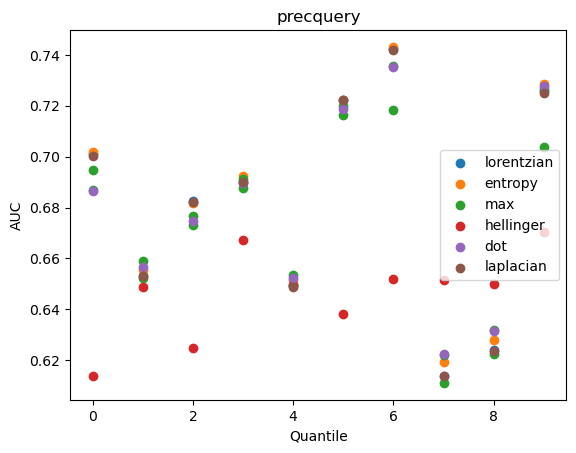

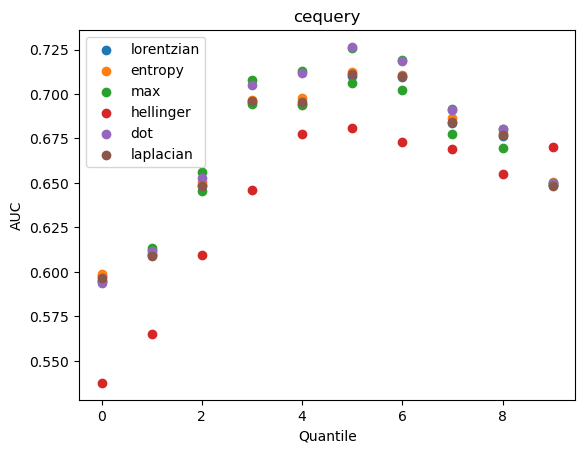

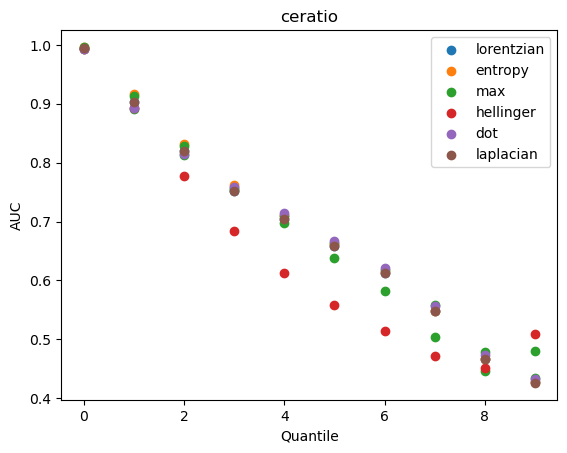

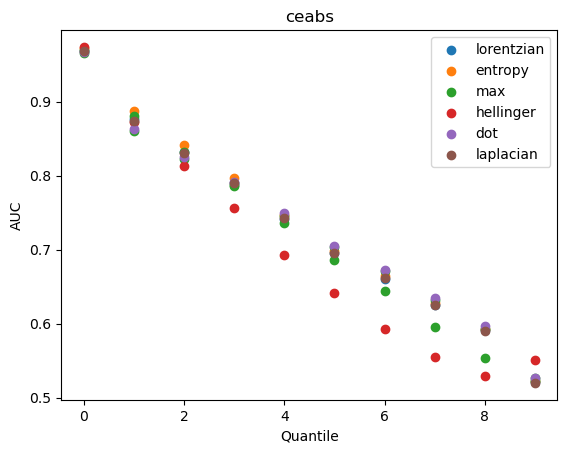

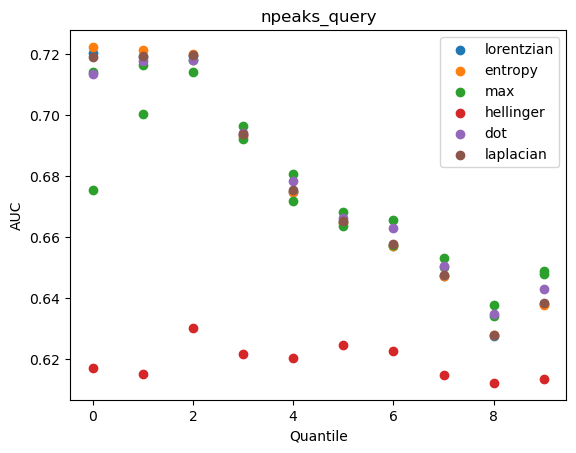

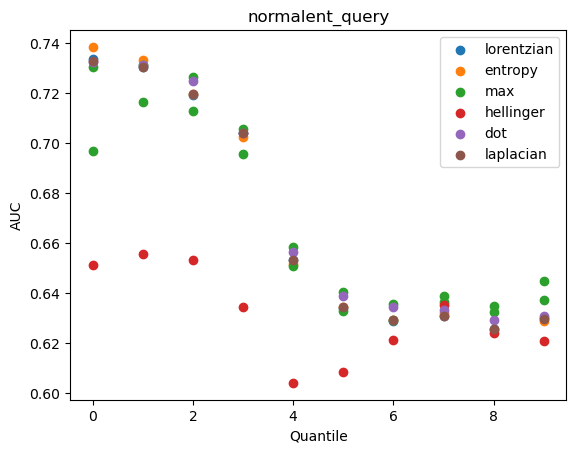

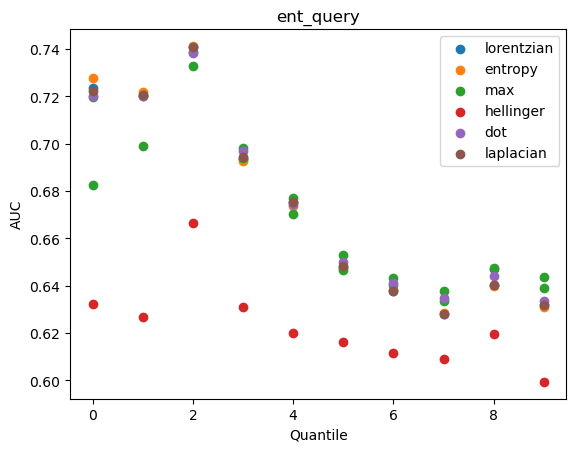

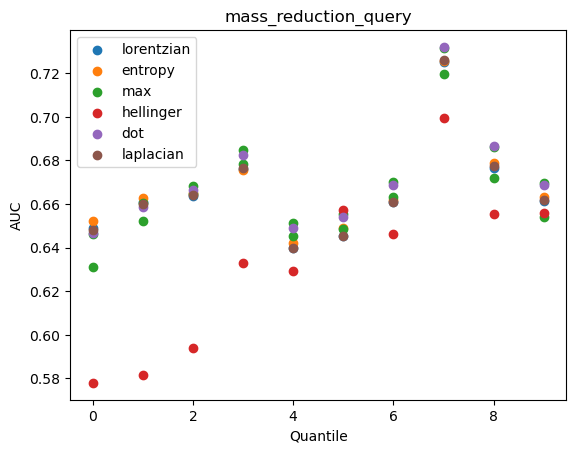

<Figure size 640x480 with 0 Axes>

In [16]:
#we will only consider the default weighting scheme here
#consider all the below metrics
reload(plotAndOrderResults)
reload(tests)
metrics=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_dot_product','dot_product','laplacian']
quantile_variables = ['precquery', 'cequery','ceratio','ceabs', 'npeaks_query','normalent_query','ent_query','mass_reduction_query']
quantile_num=10


for i in ppm_windows:

    matches = pd.read_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')
    input_data = datasetBuilder.create_model_dataset(matches,
                                                     sim_methods=metrics,
                                                     noise_threshes=[0.01],
                                                     centroid_tolerance_vals=[0.05],
                                                     centroid_tolerance_types=["da"],
                                                     powers=[1])

    metrics = input_data.columns[-len(metrics):-1]
    
    plotAndOrderResults.fig3(input_data, metrics, quantile_variables, quantile_num,f'{outputs_path}/fig3')

Figure 4: Combining Features Into Learned Model

First: Create Train and Test datasets for each ppm window

In [30]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,'orig','normalent']
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']
prec_removes=[True,False]


train_size=1.5e6
val_size=2e5
test_size=1e6

max_matches=None

target_=pd.read_pickle(target)

for i in ppm_windows:

    #read in first bases and shuffle order
    query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    query_train=query_train.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_train,target_,i,max_matches,train_size, adduct_match)
    del(query_train)

    train = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers,
                                                prec_removes
                                                )

    print(len(train))
    
    train.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
    del(matches)
    del(train)

    #read in first bases and shuffle order
    query_val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    query_val=query_val.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_val,target_,i,max_matches,val_size, adduct_match)
    del(query_val)

    val = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers,
                                                prec_removes
                                                )

    print(len(val))
    
    val.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/val_{i}_ppm.pkl')
    del(matches)
    del(val)

    #read in test queries and shuffle order
    query_test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    query_test=query_test.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_test,target_,i,max_matches,test_size, adduct_match)

    del(query_test)

    test = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers,
                                                prec_removes
                                                )
    
    test.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
    matches.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm_matches.pkl')
    del(matches)
    del(test)

100103 rows created
200039 rows created
300767 rows created
400122 rows created
500175 rows created
600408 rows created
700035 rows created
800138 rows created
900054 rows created
1000148 rows created
added 10 settings
added 10 settings
1000005
100481 rows created
200037 rows created
300026 rows created
400257 rows created
500321 rows created
600188 rows created
700114 rows created
800003 rows created
900537 rows created
1000201 rows created
added 10 settings
added 10 settings
1000310
100668 rows created
200041 rows created
300498 rows created
400433 rows created
500021 rows created
added 10 settings
added 10 settings


Then, create the indices we want to test (different features for model)

In [31]:
reload(datasetBuilder)
indices=dict()

noise_threshes=[True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True]
spec_features=[True,True, True, True, True, True, True, True]#8
sim_methods=[True,True,True,True,True, True]#6
prec_keeps=[True,False]

indices['all'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      prec_keeps,
                                                      True,
                                                      True,
                                                      True
                                                    )

indices['all_but_nonspec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      prec_keeps,
                                                      False,
                                                      False,
                                                      True
                                                    )

indices['all_but_nonspec_no_prec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      [True],
                                                      False,
                                                      False,
                                                      True
                                                    )

indices['nonspec_only']=list(range(9))
indices['nonspec_no_ppm_info']=list(range(2,7))
indices['random_half']=list(np.random.choice(indices['all'][-1], size=int(indices['all'][-1]/2), replace=False))
indices['nonspec_no_precursor']=[2,3,4,5,6]
indices['precursor_only']=[0,1,7,8]


sim_methods=[False for i in range(6)]#7
indices['no_sims'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      [True],
                                                      False,
                                                      True,
                                                      True
                                                    )

noise_threshes=[True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True]
spec_features=[False for i in range(8)]#8
sim_methods=[True for i in range(6)]#7

indices['sims_only'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      prec_keeps,
                                                      False,
                                                      False,
                                                      False,
                                                    )

indices['sims_only_no_prec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      [True],
                                                      False,
                                                      False,
                                                      False,
                                                    )


noise_threshes=[True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,False,False]
spec_features=[True for i in range(8)]#8
sim_methods=[True,True,False,False,False, False]#7

indices['small_model'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      [True],
                                                      False,
                                                      True,
                                                      False,
                                                    )

with open(f'{outputs_path}/intermediateOutputs/indices.pkl','wb') as path:
    pickle.dump(indices, path)

#del(indices)
    



In [32]:
reload(plotAndOrderResults)
reload(tests)

with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
    indices = pickle.load(path)

for i in ppm_windows:
        #import train, val and test
        train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
        val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/val_{i}_ppm.pkl')
        test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
        

        #hyperparam specifications for models, 
        #we will choose the best performer on val data for each feature subset
        models = [
                hgbc(),
                hgbc(learning_rate=0.01),
                hgbc(learning_rate=0.5),
                hgbc(max_iter=200),
                hgbc(learning_rate=0.01, max_iter=200),
                hgbc(learning_rate=0.5, max_iter=200),
                hgbc(min_samples_leaf=10),
                hgbc(learning_rate=0.01,min_samples_leaf=10),
                hgbc(learning_rate=0.5,min_samples_leaf=10),
                hgbc(max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.01, max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
                ]

        results_by_subset = tests.best_models_by_subset(indices, [int(1.1e6)], models, train, val, test)

        del(train)
        del(val)
        del(test)

        with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl', 'wb') as models:

                pickle.dump(results_by_subset, models)

        del (results_by_subset)

finished all for 1100000
finished all_but_nonspec for 1100000
finished all_but_nonspec_no_prec for 1100000
finished nonspec_only for 1100000
finished nonspec_no_ppm_info for 1100000
finished random_half for 1100000
finished nonspec_no_precursor for 1100000
finished precursor_only for 1100000
finished no_sims for 1100000
finished sims_only for 1100000
finished sims_only_no_prec for 1100000
finished small_model for 1100000


Fig 4: Plot ROC Curves by Feature Subsets

AUROC by Feature Subset for 10 ppm:
small_model: Validation: 0.93 Test: 0.94
all: Validation: 0.93 Test: 0.94
no_sims: Validation: 0.93 Test: 0.93
random_half: Validation: 0.93 Test: 0.93
all_but_nonspec_no_prec: Validation: 0.93 Test: 0.93
all_but_nonspec: Validation: 0.93 Test: 0.93
nonspec_only: Validation: 0.82 Test: 0.82
precursor_only: Validation: 0.8 Test: 0.81
sims_only_no_prec: Validation: 0.78 Test: 0.78
sims_only: Validation: 0.78 Test: 0.78
nonspec_no_precursor: Validation: 0.67 Test: 0.67
nonspec_no_ppm_info: Validation: 0.67 Test: 0.67


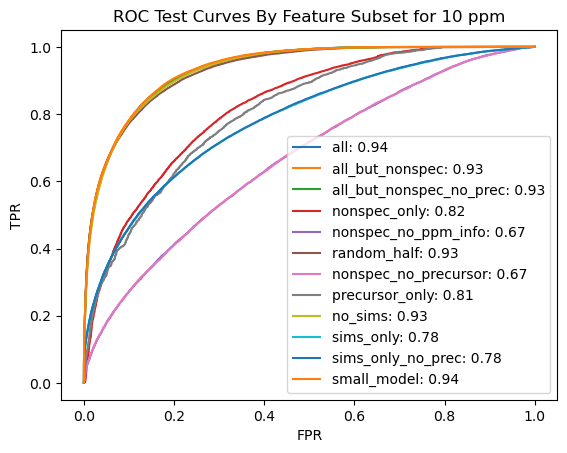

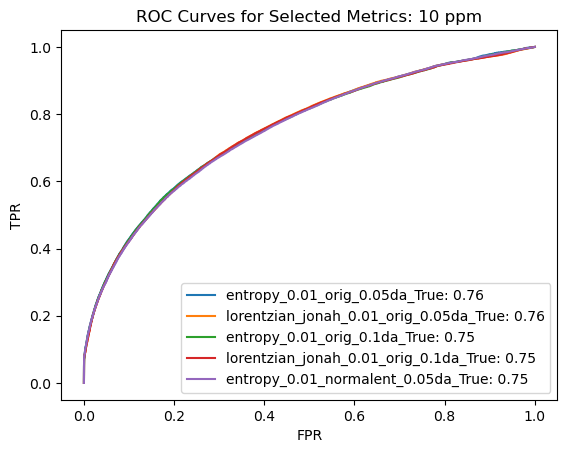

In [33]:
reload(plotAndOrderResults)
reload(tests)

top_n_metrics=5
ppm_windows=[10]

for i in ppm_windows:

    test=pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')

    with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl','rb') as path:
        res_dict = pickle.load(path)

    with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
        indices = pickle.load(path)

    plotAndOrderResults.fig4(test, res_dict, indices, f'{outputs_path}/fig4/a', i)
    plotAndOrderResults.fig4b(test, indices['sims_only'], f'{outputs_path}/fig4/b', i, top_n_metrics)    

Fig 5: Compare Performance on a Different Query Database

100014 rows created
200098 rows created
300067 rows created
400122 rows created
500104 rows created
600221 rows created
700041 rows created
800043 rows created
added 10 settings
added 10 settings
AUROC by Feature Subset for 10 ppm:
small_model: Validation: 0.93 Test: 0.82
no_sims: Validation: 0.93 Test: 0.82
random_half: Validation: 0.93 Test: 0.82
all_but_nonspec_no_prec: Validation: 0.93 Test: 0.82
all_but_nonspec: Validation: 0.93 Test: 0.82
all: Validation: 0.93 Test: 0.82
sims_only_no_prec: Validation: 0.78 Test: 0.79
sims_only: Validation: 0.78 Test: 0.79
precursor_only: Validation: 0.8 Test: 0.71
nonspec_only: Validation: 0.82 Test: 0.69
nonspec_no_ppm_info: Validation: 0.67 Test: 0.49
nonspec_no_precursor: Validation: 0.67 Test: 0.48


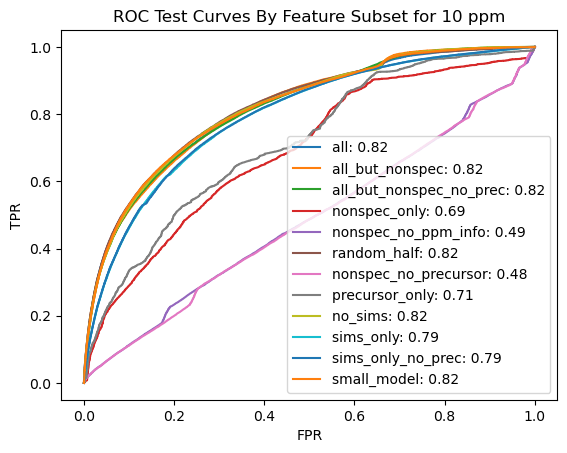

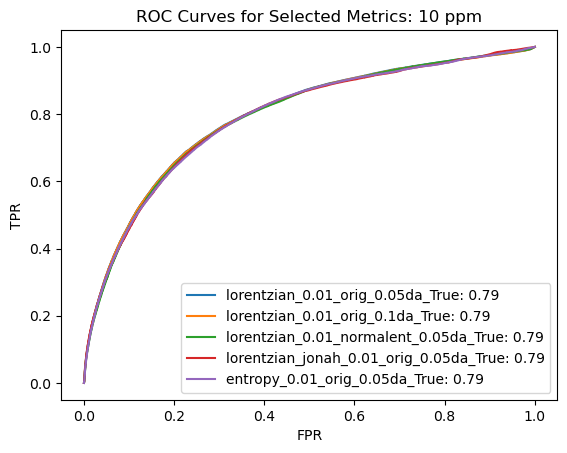

In [35]:
#set new query database
reload(plotAndOrderResults)
reload(tests)
reload(datasetBuilder)

noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,'orig','normalent']
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']


new_query = gnps

size=1e6
max_matches=None
adduct_match=False
top_n_metrics=5

for i in ppm_windows:
    
    new_query_ = pd.read_pickle(new_query)
    new_query_ = new_query_.sample(frac=1)
    target_ = pd.read_pickle(target)

    new_matches = datasetBuilder.create_matches_df_new(new_query_, target_,i ,max_matches,size,adduct_match)
    
    new_matches.to_pickle(f'{outputs_path}/fig5/matches_{i}_ppm.pkl')

    new_dataset = datasetBuilder.create_model_dataset(new_matches, 
                                                      sim_methods, 
                                                      noise_threshes, 
                                                      centroid_tolerance_vals, 
                                                      centroid_tolerance_types,
                                                      powers,
                                                      prec_keeps)
    
    with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
        indices = pickle.load(path)
        
    with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl','rb') as path:
        res_dict = pickle.load(path)

    plotAndOrderResults.fig5(new_dataset, res_dict, indices, f'{outputs_path}/fig5/a', i)
    plotAndOrderResults.fig4b(new_dataset, indices['sims_only'], f'{outputs_path}/fig5/b', i, top_n_metrics) 

    #look at all individual metric ROCS
    individual_metrics=dict()
    for i in indices['sims_only']:

        individual_metrics[new_dataset.columns[i]]=list([i])

Other Ideas:

Accuracy (In order of increasing difficulty):

-Incorporate as feature how many possible chem structures (can also restrict to NPS) exist within a certain precursor distance. (violating golden rules or not)

-include original NIST version or theoretical res as feature

-Weight different ranges of spec differently for matches (more diversity/greater accuracy)

-smush together top n results over different inchicores and come up with combined model predicting over individual inchicores

-diagnostic ion/loss classing as a feature...do they match

-kernelized smooth match

-3d struct guesses...do they match (cores, but can generalize to 3d)

Speed(In order of increasing difficulty):

-combine sim metrics and expand(apply func to df)

-exclude matches based on non-similarity features to cut down on needed comparisons

-ion tables to upper bound similarity

-only use one peak consolidation and matching protocol...then only do reweight transformations on already matched peaks for spec and sim features

In [40]:
for i in new_dataset.iloc[:,indices['small_model']].columns:
    print(i)

precquery
prectarget
cequery
cetarget
instsame
ceratio
ceabs
prec_abs_dif
prec_ppm_dif
ent_query_0.01_0.25_0.05da_True
npeaks_query_0.01_0.25_0.05da_True
normalent_query_0.01_0.25_0.05da_True
mass_reduction_query_0.01_0.25_0.05da_True
ent_target_0.01_0.25_0.05da_True
npeaks_target_0.01_0.25_0.05da_True
normalent_target_0.01_0.25_0.05da_True
mass_reduction_target_0.01_0.25_0.05da_True
lorentzian_0.01_0.25_0.05da_True
lorentzian_jonah_0.01_0.25_0.05da_True
entropy_0.01_0.25_0.05da_True
max_entropy_0.01_0.25_0.05da_True
hellinger_0.01_0.25_0.05da_True
max_bhattacharya_2_0.01_0.25_0.05da_True
ent_query_0.01_0.25_0.1da_True
npeaks_query_0.01_0.25_0.1da_True
normalent_query_0.01_0.25_0.1da_True
mass_reduction_query_0.01_0.25_0.1da_True
ent_target_0.01_0.25_0.1da_True
npeaks_target_0.01_0.25_0.1da_True
normalent_target_0.01_0.25_0.1da_True
mass_reduction_target_0.01_0.25_0.1da_True
lorentzian_0.01_0.25_0.1da_True
lorentzian_jonah_0.01_0.25_0.1da_True
entropy_0.01_0.25_0.1da_True
max_entropy_0

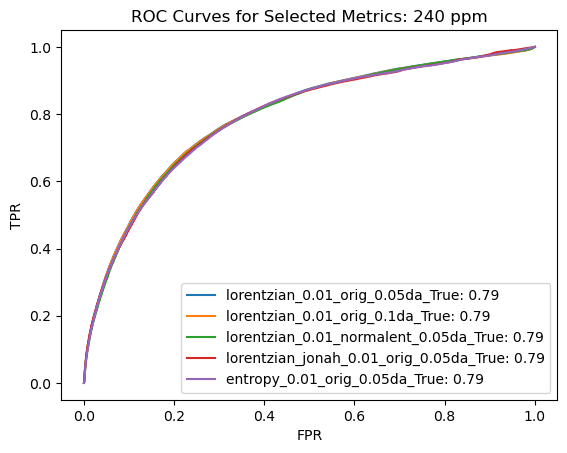

In [36]:
reload(plotAndOrderResults)
plotAndOrderResults.fig4b(new_dataset, indices['sims_only'], f'{outputs_path}/fig5/b', i, top_n_metrics)